# Poission Tutorial (Simple)

## Imports

In [1]:
# | code-fold: true
# | code-summary: "Load packages"
# | output: false

import os
import numpy as np
import jax
from jax import numpy as jnp
import pytest
from types import SimpleNamespace
from sympy import cos, pi
from time import time as gettime

from library.fvm.solver import Solver, Settings
from library.fvm.ode import RK1
import library.fvm.reconstruction as recon
import library.fvm.timestepping as timestepping
import library.fvm.flux as flux
import library.fvm.nonconservative_flux as nc_flux
from library.model.boundary_conditions import BoundaryCondition
from library.model.models.basisfunctions import Basisfunction, Legendre_shifted
from library.model.models.basismatrices import Basismatrices

from library.model.model import *
import library.model.initial_conditions as IC
import library.model.boundary_conditions as BC
import library.misc.io as io
from library.mesh.mesh import compute_derivatives
from tests.pdesoft import plots_paper


import library.mesh.mesh as petscMesh
import library.postprocessing.postprocessing as postprocessing
from library.mesh.mesh import convert_mesh_to_jax
import argparse

No module named 'precice'


## Solver definition

In [2]:
class PoissonSolver(Solver):
    def update_qaux(self, Q, Qaux, Qold, Qauxold, mesh, model, parameters, time, dt):
        T = Q[0]
        ddTdxx  = compute_derivatives(T, mesh, derivatives_multi_index=([[2]]))[:,0]
        Qaux = Qaux.at[0].set(ddTdxx)
        return Qaux


def solve(
    mesh, model, settings
):
    solver = PoissonSolver()
    
    Q, Qaux = solver.initialize(model, mesh)

    parameters = model.parameter_values

    parameters = jnp.asarray(parameters)
    
    mesh = convert_mesh_to_jax(mesh)


    pde, bcs = solver.transform_in_place(model)

    output_hdf5_path = os.path.join(settings.output.directory, f"{settings.name}.h5")
    save_fields = io.get_save_fields(output_hdf5_path, settings.output_write_all)

    assert model.dimension == mesh.dimension

    time = 0.0
    dt = 0.0
    i_snapshot = 0.0

    io.init_output_directory(settings.output.directory, settings.output_clean_dir)
    mesh.write_to_hdf5(output_hdf5_path)
    i_snapshot = save_fields(time, 0.0, i_snapshot, Q, Qaux)

    Q0 = Q
    Qnew = Q
    Qold = Q
    Qauxnew = Qaux
    Qauxold = Qaux

    min_inradius = jnp.min(mesh.cell_inradius)

    boundary_operator = solver.get_apply_boundary_conditions(mesh, bcs)
    
    time_start = gettime()

    Q = boundary_operator(time, Q, Qaux, parameters)
    Qnew = solver.implicit_solve(Q, Qaux, Qold, Qauxold, mesh, model, pde, parameters, time, dt, boundary_operator, debug=[True, False])

    time = 2.0
    i_snapshot = save_fields(time, 1., i_snapshot, Qnew, Qauxnew)

    time_start = gettime()

    print(f"Runtime: {gettime() - time_start}")

    return Q, Qaux


## Simulation

In [3]:
settings = Settings(
        name="Poisson",
        parameters={"alpha": 1.},
        compute_dt=timestepping.adaptive(CFL=0.9),
        output_snapshots=100,
        output_dir="outputs/poisson",
        output_write_all=True
    )

bc_tags = ["left", "right"]
bc_tags_periodic_to = ["right", "left"]

bcs = BC.BoundaryConditions( [
        BC.Lambda(physical_tag='left', prescribe_fields={0: lambda t, x, dx, q, qaux, p, n: 1.}),
        BC.Lambda(physical_tag='right', prescribe_fields={0: lambda t, x, dx, q, qaux, p, n: 2.}),
    ]
)

def custom_ic(x):
    Q = np.zeros(1, dtype=float)
    Q[0] = 0.
    return Q

ic = IC.UserFunction(custom_ic)


model = Poisson(
    parameters={"alpha": 1.},
    boundary_conditions=bcs,
    initial_conditions=ic,
    settings={},
)

mesh = petscMesh.Mesh.create_1d((0., 1.), 300, lsq_degree = 2)

Q, Qaux = solve(
    mesh,
    model,
    settings,
)
io.generate_vtk(os.path.join(settings.output.directory, f"{settings.name}.h5"))


Newton Iter 0: residual norm = 9.394e+04
Newton Iter 1: residual norm = 1.487e-01
Newton Iter 2: residual norm = 2.105e-07
Runtime: 7.152557373046875e-07


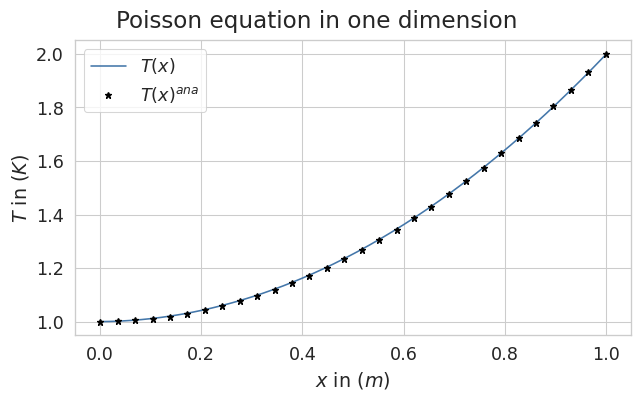

In [4]:
fig = plots_paper.plot_poisson(os.path.join(settings.output.directory, settings.name + ".h5"))